# 배추 객체 추출 관련 이미지 프로세싱 정리

## Mask-RCNN을 활용한 배추 객체 영역 추출

input image size: 634 x 423

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE           

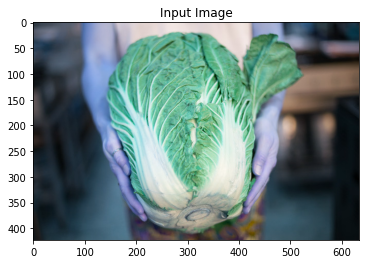

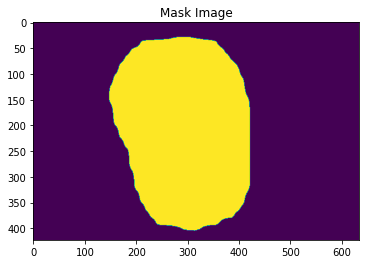

In [11]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import time
import cv2
import cv2.aruco as aruco
from matplotlib import pyplot as plt

from aidoop.mask_rcnn import model as modellib, utils
from aidoop.mask_rcnn.config import Config
from aidoop.mask_rcnn.inference import MaskRcnnDetect


COCO_WEIGHTS_PATH = "/home/jinwon/Documents/github/factory/packages/aidoop-r/object-tracker-python/logs/object-train20210610T1835/mask_rcnn_object-train_0046.h5"

DEFAULT_LOGS_DIR = "/home/jinwon/Documents/github/factory/packages/aidoop-r/object-tracker-python/logs/"

INPUT_IMAGE_PATH = "/home/jinwon/Documents/github/factory/packages/aidoop-r/object-tracker-python/examples/yolo-cabbage/samples/cabbage3.jpg"

# get width & height of input image
input_image = cv2.imread(INPUT_IMAGE_PATH, cv2.IMREAD_UNCHANGED)
height = input_image.shape[0]
width = input_image.shape[1]
print(f"input image size: {width} x {height}")


mrdetect = MaskRcnnDetect(COCO_WEIGHTS_PATH, DEFAULT_LOGS_DIR)

mask_list = mrdetect.detect_object_by_path(INPUT_IMAGE_PATH)

mask_image = mrdetect.get_mask_image(mask_list, width, height)

plt.imshow(input_image)
plt.title('Input Image')
plt.show()

plt.imshow(mask_image)
plt.title('Mask Image')
plt.show()






## 추출된 영역 확인

In [20]:
import numpy as np
import math

def get_line_length(x1, y1, x2, y2):
    return math.sqrt((x2-x1)**2+(y2-y1)**2)

threshold result: 0.0


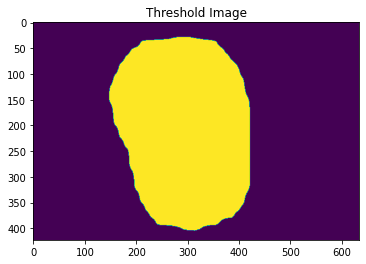

((298.233154296875, 210.88601684570312), (264.57122802734375, 381.6381530761719), -14.743562698364258)
coordinate #1: (298.233154296875, 210.88601684570312)
coordinate #2: (264.57122802734375, 381.6381530761719)
rotate angle: -14.743562698364258


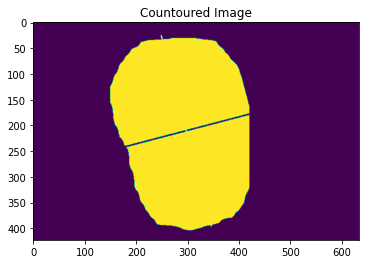

In [21]:
ret, thr_image = cv2.threshold(mask_image, 127, 255, cv2.THRESH_OTSU)
print(f"threshold result: {ret}")

plt.imshow(thr_image)
plt.title('Threshold Image')
plt.show()


contours,_ = cv2.findContours(thr_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

mask_image_copy = mask_image.copy()
for countour in contours:
    (x,y,w,h) = cv2.boundingRect(countour)
    cv2.rectangle(mask_image_copy, (x, y), (x + w, y + h), (0, 255, 255), 2)

    rect = cv2.minAreaRect(countour)
    print(rect)
    print('coordinate #1:', rect[0])
    print('coordinate #2:', rect[1])
    print('rotate angle:', rect[2])

    # get the rectangle coordinates of RotateRect
    box = cv2.boxPoints(rect)

    # to integer
    box = np.int0(box)

    # draw box
    cv2.drawContours(mask_image_copy,[box],0,(0,0,255),2)

    # draw center line
    xx1 = np.int0((box[0][0] + box[1][0])/2)
    yy1 = np.int0((box[0][1] + box[1][1])/2)
    xx2 = np.int0((box[2][0] + box[3][0])/2)
    yy2 = np.int0((box[2][1] + box[3][1])/2)

    len1 = get_line_length(xx1, yy1, xx2, yy2)

    xx3 = np.int0((box[0][0] + box[3][0])/2)
    yy3 = np.int0((box[0][1] + box[3][1])/2)
    xx4 = np.int0((box[2][0] + box[1][0])/2)
    yy4 = np.int0((box[2][1] + box[1][1])/2)  

    len2 = get_line_length(xx3, yy3, xx4, yy4)  
    
    if(len1 >= len2):
        color1 = (255, 0, 0)
        color2 = (0, 255, 0)
    else:
        color1 = (0, 255, 0)
        color2 = (255, 0, 0)

    cv2.line(mask_image_copy, (xx1, yy1), (xx2, yy2), color1, 2)
    cv2.line(mask_image_copy, (xx3, yy3), (xx4, yy4), color2, 2)



#cv2.rectangle(mask_image_copy, (x, y), (x + w, y + h), (0, 0, 255), 2)
# box = cv2.boxPoints(rect)
# box = np.int0(box)
# cv2.drawContours(mask_image_copy, [box], 0, (0, 0, 255), 2)

#cv2.drawContours(mask_image_copy, contours, -1, (0, 0, 255), 1)
plt.imshow(mask_image_copy)
plt.title('Countoured Image')
plt.show()




## Yolo에 대한 결과값 처리


In [52]:
out_boxes, out_scores, out_classes, num_boxes = yolo_result

In [53]:
print('num_boxes')
print(num_boxes)

num_boxes
[1]


In [61]:
print('out_boxes')
print(out_boxes)

out_boxes
[[[ 17. 164. 404. 428.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0

In [55]:
print('out_scores')
print(out_scores)

out_scores
[[0.9952387 0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.       ]]


In [56]:
print('out_classes')
print(out_classes)

out_classes
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


original image shape:
(423, 634, 3)
outboxes: 
[ 17. 164. 404. 428.]
[17, 164, 404, 428]


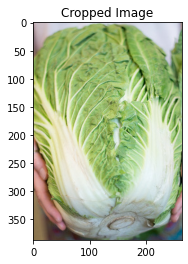

In [62]:
# check original image shape
print("original image shape:")
print(original_cvt_image.shape)
print("outboxes: ")
print(out_boxes[0][0])

# float list to integer list
roi_region = list(map(int, out_boxes[0][0]))
print(roi_region)

# create cropped image for cabbage object
cropped_image = original_image[roi_region[0]:roi_region[2], roi_region[1]:roi_region[3]]
plt.imshow(cropped_image)
plt.title('Cropped Image')
plt.show()


## Image processing for cabbage object

173.0


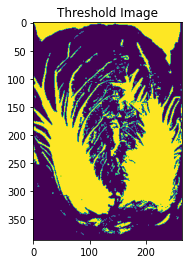

In [66]:
gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
ret, thr_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_OTSU)
print(ret)

plt.imshow(thr_image)
plt.title('Threshold Image')
plt.show()

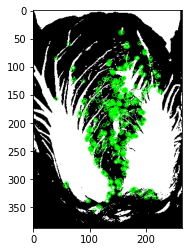

(<matplotlib.image.AxesImage at 0x7f177d4c8f28>, None)

In [74]:
orb = cv2.ORB_create()

# find the keypoints with ORB
kp = orb.detect(thr_image,None)
# compute the descriptors with ORB
kp, des = orb.compute(thr_image, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(thr_image, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()